# Performance of Inception-v3

In [14]:
% matplotlib inline

import os
import matplotlib.pyplot as plt

from tests.other.googlenet.util import ExpResults

In [13]:
plotproperties = {'font.size': 13,
                  'axes.titlesize': 'xx-large',
                  'axes.labelsize': 'xx-large',
                  'xtick.labelsize': 'xx-large',
                  'xtick.major.size': 7,
                  'xtick.minor.size': 5,
                  'ytick.labelsize': 'xx-large',
                  'ytick.major.size': 7,
                  'ytick.minor.size': 5,
                  'legend.fontsize': 'xx-large',
                  'figure.figsize': (7, 6),
                  'savefig.dpi': 300,
                  'savefig.format': 'jpg'}

import matplotlib as mpl
mpl.rcParams.update(plotproperties)

## Parameters and definitions

In [3]:
log_dir = '/home/rbodo/.snntoolbox/data/imagenet/inceptionV3/keras/log'
runlabel_analog = '03'
path_analog = os.path.join(log_dir, 'gui', runlabel_analog)

clamp = 470 - 1

scale = 1e3  # Scale from Million to Billion operations

In [4]:
import numpy as np
last_batch_idx = str(len(os.listdir(os.path.join(path_analog, 'log_vars'))) - 1)
a = dict(np.load(os.path.join(path_analog, 'log_vars', last_batch_idx + '.npz')))
a['operations_ann'] = 11426432192 / 1e6
a['top1err_ann'] = 1 - 76.12 / 100
a['top5err_ann'] = 1 - 92.99 / 100
np.savez_compressed(os.path.join(path_analog, 'log_vars', last_batch_idx + '.npz'), **a)

## Plot number of operations vs time

In [5]:
exp_analog = ExpResults(path_analog, 'SNN', '.', scale=scale)
experiments = [exp_analog]

Using Theano backend.


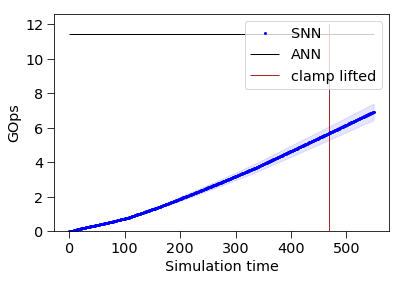

In [16]:
for exp in experiments:
    plt.plot(exp.time, exp.mean_computations_t, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.mean_computations_t-exp.std_computations_t, exp.mean_computations_t+exp.std_computations_t, alpha=0.1, color=exp.color1)
plt.hlines(c_ANN, 0, experiments[0].time[-1], linewidth=1, label='ANN')
plt.vlines(clamp, 0, 12, linewidth=1, label='clamp lifted', colors='brown')
plt.ylabel('GOps')
plt.xlabel('Simulation time')
plt.legend()
plt.ylim(0, None)
plt.savefig(os.path.join(log_dir, 'ops_vs_t'), bbox_inches='tight')

## Plot error vs time

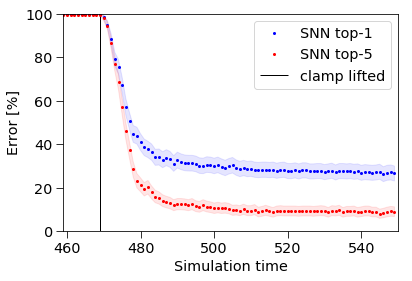

In [17]:
for exp in experiments:
    plt.plot(exp.time, exp.e1_mean, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label+' top-1')
    plt.fill_between(exp.time, exp.e1_mean-exp.e1_confidence95, exp.e1_mean+exp.e1_confidence95, alpha=0.1, color=exp.color1)
    plt.plot(exp.time, exp.e5_mean, exp.marker, color=exp.color5, markersize=exp.markersize, label=exp.label+' top-5')
    plt.fill_between(exp.time, exp.e5_mean-exp.e5_confidence95, exp.e5_mean+exp.e5_confidence95, alpha=0.1, color=exp.color5)
plt.vlines(clamp, 0, 100, linewidth=1, label='clamp lifted')
plt.ylabel('Error [%]')
plt.xlabel('Simulation time')
plt.xlim(clamp-10, 550)
plt.ylim(0, 100)
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_t'), bbox_inches='tight')

## Plot error vs operations

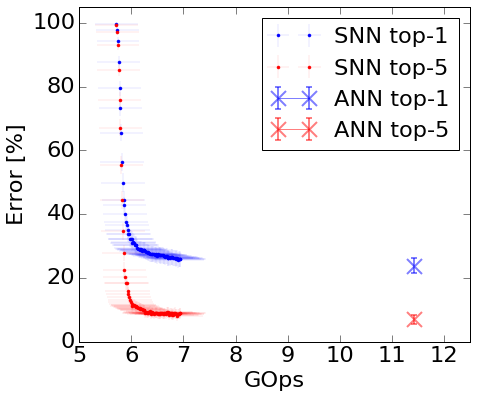

In [12]:
show_numbers = False

exp = experiments[0]

plt.errorbar(exp.mean_computations_t[clamp:], exp.e1_mean[clamp:], xerr=exp.std_computations_t[clamp:],
             yerr=exp.e1_confidence95[clamp:], fmt=exp.marker, label=exp.label+' top-1', capsize=0, elinewidth=0.1, color=exp.color1)
plt.errorbar(exp.mean_computations_t[clamp:], exp.e5_mean[clamp:], xerr=exp.std_computations_t[clamp:],
             yerr=exp.e5_confidence95[clamp:], fmt=exp.marker, label=exp.label+' top-5', capsize=0, elinewidth=0.1, color=exp.color5)

plt.errorbar(exp.operations_ann, exp.e1_ann, marker='x', label='ANN top-1', color=exp.color1, markersize=15,
             yerr=exp.e1_confidence95_ann, elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
plt.errorbar(exp.operations_ann, exp.e5_ann, marker='x', label='ANN top-5', color=exp.color5, markersize=15,
             yerr=exp.e5_confidence95_ann, elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)

if show_numbers:
    plt.annotate('({:.2f}, {:.2f})'.format(exp.operations_ann, exp.e1_ann), xy=(exp.operations_ann - 0.15, exp.e1_ann + 10), color=exp.color1)
    plt.annotate('({:.2f}, {:.2f})'.format(exp.operations_ann, exp.e5_ann), xy=(exp.operations_ann - 0.15, exp.e5_ann + 10), color=exp.color5)
    plt.annotate('({:.2f}, {:.2f})'.format(exp.op1_optimal, exp.e1_optimal), xy=(exp.op1_optimal, exp.e1_optimal),
                 xytext=(exp.op1_optimal, exp.e1_optimal + 10),
                 arrowprops=dict(color=exp.color1, shrink=0.05, width=5, headwidth=10), color=exp.color1)
    plt.annotate('({:.2f}, {:.2f})'.format(exp.op5_optimal, exp.e5_optimal), xy=(exp.op5_optimal, exp.e5_optimal),
                 xytext=(exp.op5_optimal, exp.e5_optimal + 10),
                 arrowprops=dict(color=exp.color5, shrink=0.05, width=5, headwidth=10), color=exp.color5)

plt.ylim(0, 105)
plt.xlim(None, 12.5)
plt.ylabel('Error [%]')
plt.xlabel('GOps')
plt.legend(loc='upper right')
# plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')

In [7]:
for exp in experiments:
    print('SNN top-1 best:              ({:.2f} MOps/frame, {:.2f} %)'.format(exp.op1_0, exp.e1_0))
    print('SNN top-1 -1%:               ({:.2f} MOps/frame, {:.2f} %)'.format(exp.op1_1, exp.e1_1))
    print('SNN top-1 compromise:  ({:.2f} MOps/frame, {:.2f} %)'.format(exp.op1_optimal, exp.e1_optimal))
    print('SNN top-5 best:              ({:.2f} MOps/frame, {:.2f} %)'.format(exp.op5_0, exp.e5_0))
    print('SNN top-5 -1%:               ({:.2f} MOps/frame, {:.2f} %)'.format(exp.op5_1, exp.e5_1))
    print('SNN top-5 compromise:  ({:.2f} MOps/frame, {:.2f} %)'.format(exp.op5_optimal, exp.e5_optimal))
    print('ANN top-1:                     ({:.2f} MOps/frame, {:.2f} %)'.format(exp.operations_ann, exp.e1_ann))
    print('ANN top-5:                     ({:.2f} MOps/frame, {:.2f} %)'.format(exp.operations_ann, exp.e5_ann))

SNN top-1 best:              (6.90 MOps/frame, 25.73 %)
SNN top-1 -1%:               (6.65 MOps/frame, 26.73 %)
SNN top-1 compromise:  (5.97 MOps/frame, 32.27 %)
SNN top-5 best:              (6.88 MOps/frame, 8.05 %)
SNN top-5 -1%:               (6.33 MOps/frame, 9.05 %)
SNN top-5 compromise:  (5.93 MOps/frame, 15.84 %)
ANN top-1:                     (11.43 MOps/frame, 23.88 %)
ANN top-5:                     (11.43 MOps/frame, 7.01 %)
